In [55]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import shap
from math import sqrt
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.layers import Input,LSTM,Dense,Dropout,RepeatVector,TimeDistributed
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os

In [56]:
df=pd.read_csv("wind_dataset.csv")

In [57]:
print(df.head())

         DATE   WIND  IND  RAIN  IND.1  T.MAX  IND.2  T.MIN  T.MIN.G
0  1961-01-01  13.67    0   0.2    0.0    9.5    0.0    3.7     -1.0
1  1961-01-02  11.50    0   5.1    0.0    7.2    0.0    4.2      1.1
2  1961-01-03  11.25    0   0.4    0.0    5.5    0.0    0.5     -0.5
3  1961-01-04   8.63    0   0.2    0.0    5.6    0.0    0.4     -3.2
4  1961-01-05  11.92    0  10.4    0.0    7.2    1.0   -1.5     -7.5


In [58]:
print(df.shape)

(6574, 9)


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6574 entries, 0 to 6573
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   DATE     6574 non-null   object 
 1   WIND     6574 non-null   float64
 2   IND      6574 non-null   int64  
 3   RAIN     6574 non-null   float64
 4   IND.1    6513 non-null   float64
 5   T.MAX    5953 non-null   float64
 6   IND.2    6513 non-null   float64
 7   T.MIN    5900 non-null   float64
 8   T.MIN.G  6214 non-null   float64
dtypes: float64(7), int64(1), object(1)
memory usage: 462.4+ KB


In [60]:
df['DATE']=pd.to_datetime(df['DATE'])
df=df.sort_values(by='DATE')

In [61]:
df.head()

,DATE,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
0,1961-01-01,13.67,0,0.2,0.0,9.5,0.0,3.7,-1.0
1,1961-01-02,11.50,0,5.1,0.0,7.2,0.0,4.2,1.1
2,1961-01-03,11.25,0,0.4,0.0,5.5,0.0,0.5,-0.5
3,1961-01-04,8.63,0,0.2,0.0,5.6,0.0,0.4,-3.2
4,1961-01-05,11.92,0,10.4,0.0,7.2,1.0,-1.5,-7.5


In [62]:
df.isnull().sum()

,0
DATE,0
WIND,0
IND,0
RAIN,0
IND.1,61
T.MAX,621
IND.2,61
T.MIN,674
T.MIN.G,360


visualization


In [63]:
df['IND.1'] = df['IND.1'].fillna(df['IND.1'].mean())
df['IND.2'] = df['IND.2'].fillna(df['IND.2'].mean())
df['T.MAX'] = df['T.MAX'].fillna(df['T.MAX'].mean())
df['T.MIN'] = df['T.MIN'].fillna(df['T.MIN'].mean())
df['T.MIN.G'] = df['T.MIN.G'].fillna(df['T.MIN.G'].mean())

In [64]:
df.isnull().sum()

,0
DATE,0
WIND,0
IND,0
RAIN,0
IND.1,0
T.MAX,0
IND.2,0
T.MIN,0
T.MIN.G,0


<Axes: xlabel='DATE'>

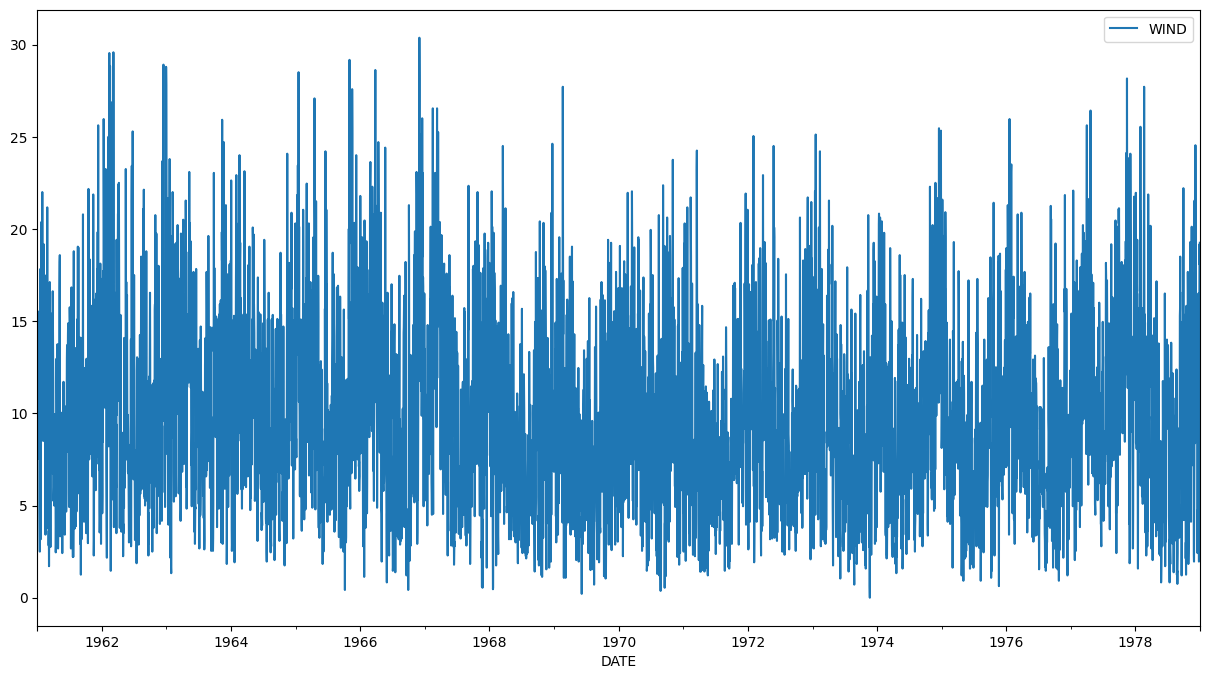

In [65]:
df.plot(x='DATE',y='WIND',figsize=(15,8))

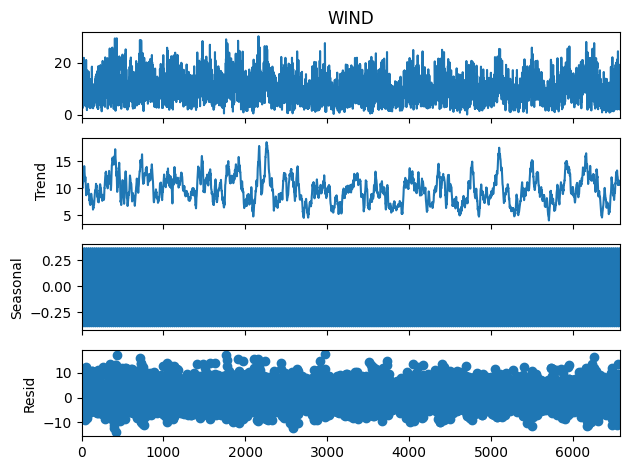

In [66]:
from statsmodels.tsa.seasonal import seasonal_decompose
result=seasonal_decompose(df['WIND'],model='additive',period=24)
result.plot()
plt.show()

<Axes: >

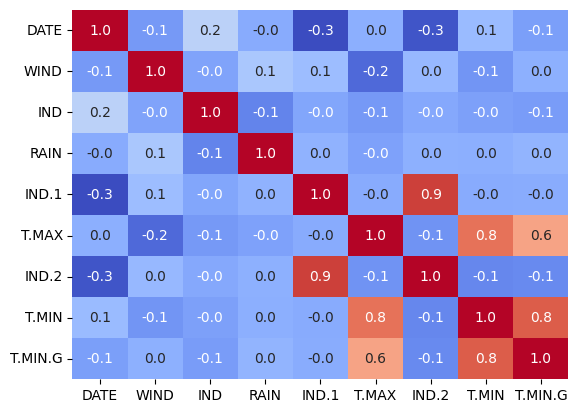

In [67]:
sns.heatmap(df.corr(),annot=True,cmap='coolwarm',fmt='.1f',cbar=False)

<Axes: ylabel='WIND'>

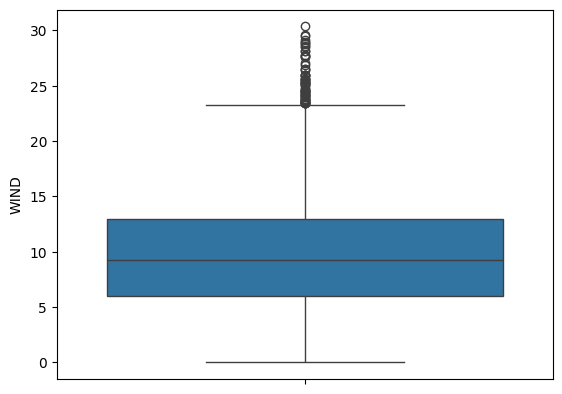

In [68]:
sns.boxplot(df['WIND'])

<Axes: ylabel='RAIN'>

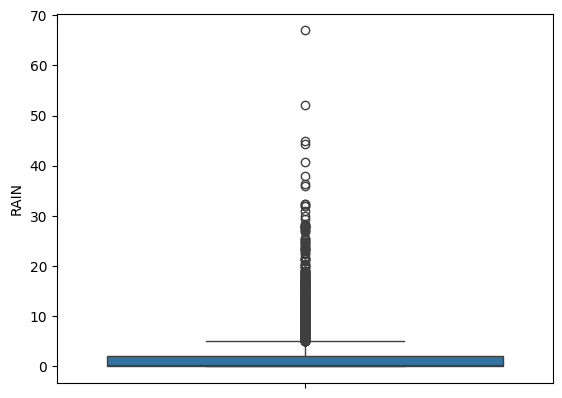

In [69]:
sns.boxplot(df['RAIN'])

<Axes: ylabel='T.MAX'>

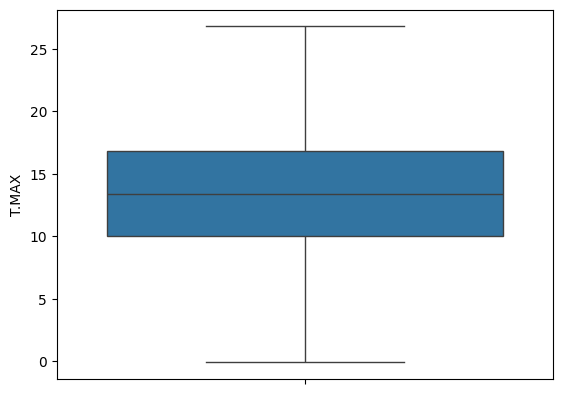

In [70]:
sns.boxplot(df['T.MAX'])

<Axes: ylabel='T.MIN'>

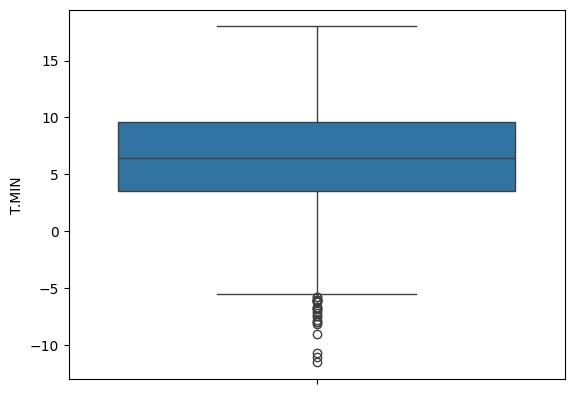

In [71]:
sns.boxplot(df['T.MIN'])

<Axes: ylabel='T.MIN.G'>

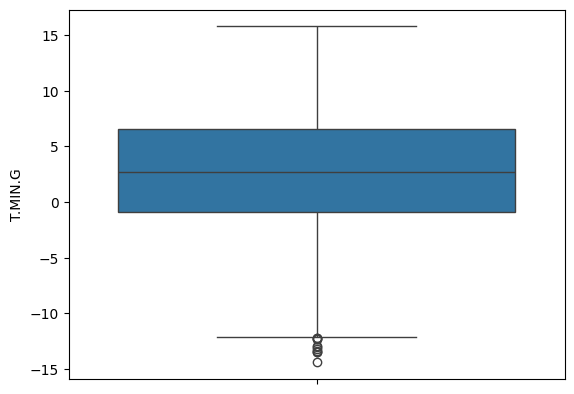

In [72]:
sns.boxplot(df['T.MIN.G'])

<Axes: xlabel='IND', ylabel='Count'>

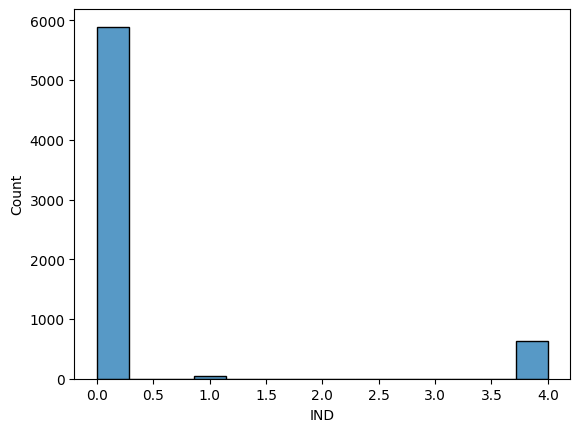

In [73]:
sns.histplot(df['IND'])

<Axes: xlabel='IND.1', ylabel='Count'>

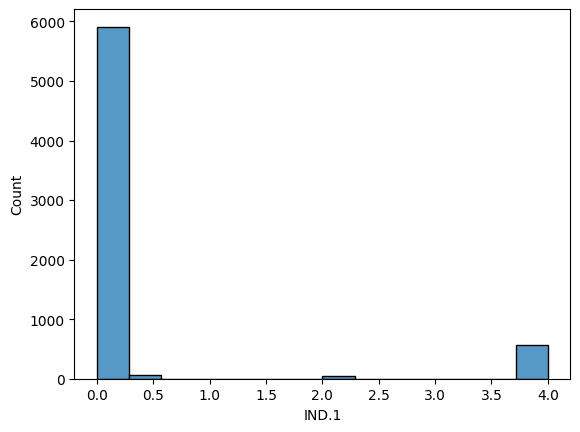

In [74]:
sns.histplot(df['IND.1'])

<Axes: xlabel='IND.2', ylabel='Count'>

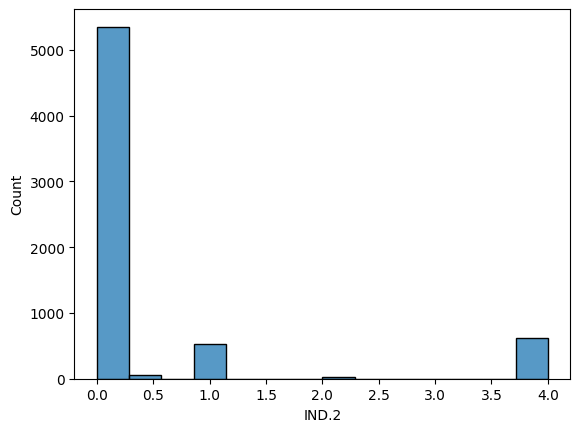

In [75]:
sns.histplot(df['IND.2'])

In [76]:
df=df.set_index('DATE')

In [77]:
target=df['WIND']

In [78]:
n_past=24
n_future=7
n_features=8

In [79]:
print(f'Creating features:n_past={n_past},n_future={n_future},n_features={n_features}')

Creating features:n_past=24,n_future=7,n_features=8


Scaling

In [80]:
scaler=MinMaxScaler()
scaled_values=scaler.fit_transform(df)
scaled_df=pd.DataFrame(scaled_values,columns=df.columns,index=df.index)

In [81]:
scaled_df.head()

,WIND,IND,RAIN,IND.1,T.MAX,IND.2,T.MIN,T.MIN.G
DATE,,,,,,,,
1961-01-01,0.450115,0.0,0.002985,0.0,0.356877,0.00,0.515254,0.443709
1961-01-02,0.378663,0.0,0.076119,0.0,0.271375,0.00,0.532203,0.513245
1961-01-03,0.370431,0.0,0.005970,0.0,0.208178,0.00,0.406780,0.460265
1961-01-04,0.284162,0.0,0.002985,0.0,0.211896,0.00,0.403390,0.370861
1961-01-05,0.392493,0.0,0.155224,0.0,0.271375,0.25,0.338983,0.228477


Sequence for lstm

In [82]:
values=scaled_df.values
n_samples=len(values)
n_features=values.shape[1]

In [83]:
X=[]
Y=[]
for i in range(n_samples-n_past-n_future):
    X.append(values[i:i+n_past,:])
    target_idx=list(scaled_df.columns).index('WIND')
    Y.append(values[i+n_past:i+n_past+n_future,target_idx])

In [84]:
X=np.array(X)
Y=np.array(Y)

In [85]:
print('created sequences X shape:',X.shape,'Y.shape:',Y.shape)

created sequences X shape: (6543, 24, 8) Y.shape: (6543, 7)


In [86]:
train_ratio=0.8
train_size=int(len(X)*train_ratio)
x_train,x_test=X[:train_size],X[train_size:]
y_train,y_test=Y[:train_size],Y[train_size:]
print('Train Samples:',x_train.shape[0],'Test Samples:',x_test.shape[0])

Train Samples: 5234 Test Samples: 1309


LSTM MODEL

In [87]:
enc_steps=n_past
dec_steps=n_future
n_feat=n_features

In [88]:
latent_dim=128

In [89]:
model=Sequential()
model.add(LSTM(64,return_sequences=True,input_shape=(n_past,n_features)))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(n_future))

model.compile(optimizer='adam',loss='mse')
model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 24, 64)         │        18,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 24, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,335 (122.40 KB)

 Trainable params: 31,335 (122.40 KB)

 Non-trainable params: 0 (0.00 B)

In [90]:
OUTPUT_DIR='output_models'
os.makedirs(OUTPUT_DIR,exist_ok=True)

In [91]:
early=EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True,verbose=1)
path=os.path.join(OUTPUT_DIR,'best_lstm_model.h5')
checkpoint=ModelCheckpoint(path,monitor='val_loss',verbose=1,save_best_only=True,mode='min')

In [92]:
history=model.fit(x_train,y_train,validation_split=0.1,epochs=10,batch_size=32,callbacks=[early,checkpoint],verbose=2)

Epoch 1/10

Epoch 1: val_loss improved from inf to 0.02006, saving model to output_models/best_lstm_model.h5


148/148 - 9s - 60ms/step - loss: 0.0353 - val_loss: 0.0201
Epoch 2/10

Epoch 2: val_loss did not improve from 0.02006
148/148 - 9s - 63ms/step - loss: 0.0279 - val_loss: 0.0202
Epoch 3/10

Epoch 3: val_loss did not improve from 0.02006
148/148 - 4s - 24ms/step - loss: 0.0269 - val_loss: 0.0203
Epoch 4/10

Epoch 4: val_loss did not improve from 0.02006
148/148 - 3s - 22ms/step - loss: 0.0261 - val_loss: 0.0201
Epoch 5/10

Epoch 5: val_loss did not improve from 0.02006
148/148 - 6s - 43ms/step - loss: 0.0256 - val_loss: 0.0204
Epoch 6/10

Epoch 6: val_loss did not improve from 0.02006
148/148 - 4s - 25ms/step - loss: 0.0256 - val_loss: 0.0207
Epoch 7/10

Epoch 7: val_loss did not improve from 0.02006
148/148 - 3s - 23ms/step - loss: 0.0252 - val_loss: 0.0205
Epoch 8/10

Epoch 8: val_loss did not improve from 0.02006
148/148 - 3s - 23ms/step - loss: 0.0250 - val_loss: 0.0207
Epoch 9/10

Epoch 9: val_loss did not improve from 0.02006
148/148 - 5s - 34ms/step - loss: 0.0248 - val_loss: 0.02

In [93]:
model.save(os.path.join(OUTPUT_DIR,'final_lstm_model.h5'))

In [94]:
pred=model.predict(x_test)
pred=pred.reshape(pred.shape[0],pred.shape[1])

41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step


In [95]:
last_obj=x_test[:,-1,:]

In [96]:
pred_rescaled=[]
actual_rescaled=[]

In [97]:
wind_col_idx = list(scaled_df.columns).index('WIND')
pred_rescaled=[]
actual_rescaled=[]
for i in range(pred.shape[0]):
  pred_rows = np.tile(last_obj[i,:],(dec_steps,1))
  actual_rows = np.tile(last_obj[i,:],(dec_steps,1))
  for j in range(dec_steps):
    pred_rows[j, wind_col_idx] = pred[i,j]
    actual_rows[j, wind_col_idx] = y_test[i,j]
  pred_inv = scaler.inverse_transform(pred_rows)[:, wind_col_idx]
  act_inv = scaler.inverse_transform(actual_rows)[:, wind_col_idx]
  pred_rescaled.append(pred_inv)
  actual_rescaled.append(act_inv)

In [98]:
pred_rescaled=np.array(pred_rescaled)
actual_rescaled=np.array(actual_rescaled)

In [99]:
rmse_per_h=np.sqrt(mean_squared_error(actual_rescaled, pred_rescaled, multioutput='raw_values'))
print(f'RMSE (per horizon): {rmse_per_h}')
mae_per_h=np.mean(np.abs(actual_rescaled-pred_rescaled),axis=0)
print(f'MAE (per horizon): {mae_per_h}')
mape_per_h = np.mean(np.abs((actual_rescaled - pred_rescaled) / actual_rescaled), axis=0) * 100
print(f'MAPE(per horizon):{mape_per_h}')

RMSE (per horizon): [4.52212096 4.61711881 4.62628284 4.62566249 4.6706802  4.65840406
 4.66188517]
MAE (per horizon): [3.57306329 3.64027301 3.6421681  3.62788242 3.68424317 3.72717606
 3.69721079]
MAPE(per horizon):[61.53313503 61.800282   61.76563313 60.38823486 61.59957391 67.42504474
 63.5343741 ]


In [100]:
result=pd.DataFrame({
    "Metric":['MAE','RMSE','MAPE'],
    "Value":[mae_per_h,rmse_per_h,mape_per_h]
})
result.to_csv(os.path.join(OUTPUT_DIR,'metrics_per_horizon.csv'),index=False)

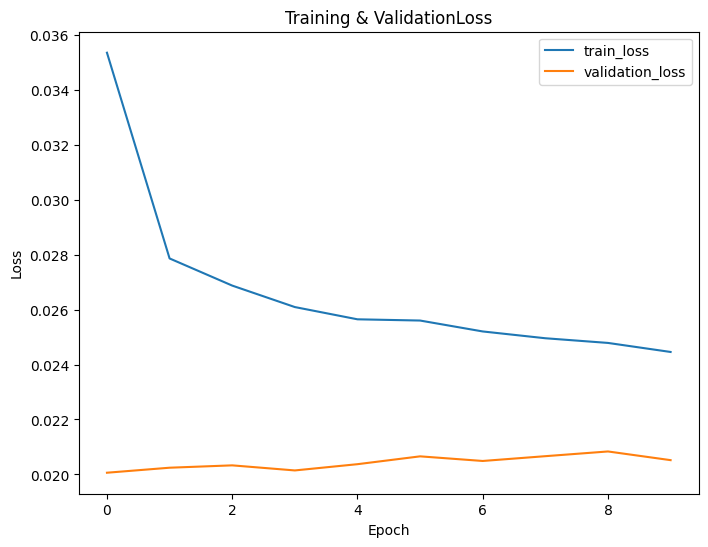

In [101]:
plt.figure(figsize=(8,6))
plt.plot(history.history['loss'],label='train_loss')
plt.plot(history.history['val_loss'],label='validation_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training & ValidationLoss')
plt.savefig(os.path.join(OUTPUT_DIR,'training_validation_loss.png'))
plt.show()

In [102]:
plots=min(20,pred_rescaled.shape[0])
for h in range(min(3,dec_steps)):
  plt.figure(figsize=(8,6))
  plt.plot(actual_rescaled[:plots,h],label='actual')
  plt.plot(pred_rescaled[:plots,h],label='predicted')
  plt.xlabel('Time')
  plt.ylabel('WIND')
  plt.title(f'predicted vs Actual for horizon {h+1}')
  plt.legend()
  plt.savefig(os.path.join(OUTPUT_DIR,f'pred_vs_actual_h{h+1}.png'))
  plt.close()
  plt.show()

Shap

In [103]:
shap_sample_size=min(200,x_train.shape[0])
data=x_train[np.random.choice(x_train.shape[0],shap_sample_size,replace=False)]
explainer=None

In [104]:
try:
  shap_model = Model(inputs=model.inputs, outputs=model.output[:, 0, :])
  explainer = shap.DeepExplainer(shap_model, x_train[:100])
  shap_values = explainer.shap_values(x_test[:50])
  if isinstance(shap_values, list) and len(shap_values) > 0:
    shap_val = shap_values[0]
  else:
    shap_val = shap_values
  shap_mean_abs_per_sample = np.mean(np.abs(shap_val), axis=1)
  shap_feature_importance = np.mean(shap_mean_abs_per_sample, axis=0)
  feature_names = list(scaled_df.columns)
  feat_df = pd.DataFrame({'feature': feature_names, 'importance': shap_feature_importance})
  feat_df = feat_df.sort_values(by='importance', ascending=False)
  feat_df.to_csv(os.path.join(OUTPUT_DIR, 'shap_feature_importance.csv'), index=False)
  plt.figure(figsize=(8, 6))
  topk = min(10, len(feat_df))
  plt.barh(feat_df['feature'].iloc[:topk][::-1], feat_df['importance'].iloc[:topk][::-1])
  plt.xlabel('Mean Absolute SHAP Value')
  plt.ylabel('Feature')
  plt.title('Top Feature Importance (for first prediction horizon)')
  plt.savefig(os.path.join(OUTPUT_DIR, 'shap_feature_importance.png'))
  plt.close()
except Exception as e:
  print('DeepExplainer Failed', e)
  print('Falling back to SHAP KernelExplainer (with appropriate reshaping)')
  import shap as _shap
  def f(x):
      x_reshaped = x.reshape(-1, n_past, n_features)
      return model.predict(x_reshaped)[:, 0]
  bg_flat = x_train[np.random.choice(x_train.shape[0], min(50, x_train.shape[0]), replace=False)].reshape(-1, n_past * n_features)
  ke = _shap.KernelExplainer(f, bg_flat)
  x_test_flat = x_test[:20].reshape(-1, n_past * n_features)
  shap_values = ke.shap_values(x_test_flat, nsamples=100)
  if isinstance(shap_values, list) and len(shap_values) > 0:
    shap_val_kernel = shap_values[0]
  else:
    shap_val_kernel = shap_values
  shap_val_kernel_reshaped = shap_val_kernel.reshape(x_test[:20].shape[0], n_past, n_features)
  shap_mean_abs_per_feature_per_sample_kernel = np.mean(np.abs(shap_val_kernel_reshaped), axis=1)
  shap_feature_importance_kernel = np.mean(shap_mean_abs_per_feature_per_sample_kernel, axis=0)
  feature_names = list(scaled_df.columns)
  feat_df_kernel = pd.DataFrame({'feature': feature_names, 'importance': shap_feature_importance_kernel})
  feat_df_kernel = feat_df_kernel.sort_values(by='importance', ascending=False)
  feat_df_kernel.to_csv(os.path.join(OUTPUT_DIR, 'shap_feature_importance_kernel.csv'), index=False)
  plt.figure(figsize=(8, 6))
  topk = min(10, len(feat_df_kernel))
  plt.barh(feat_df_kernel['feature'].iloc[:topk][::-1], feat_df_kernel['importance'].iloc[:topk][::-1])
  plt.xlabel('Mean Absolute SHAP Value')
  plt.ylabel('Feature')
  plt.title('Top Feature Importance (KernelExplainer for first prediction horizon)')
  plt.savefig(os.path.join(OUTPUT_DIR, 'shap_feature_importance_kernel.png'))
  plt.close()

  pd.DataFrame(shap_val_kernel_reshaped.reshape(shap_val_kernel_reshaped.shape[0], -1)).to_csv(os.path.join(OUTPUT_DIR, 'shap_values_kernel.csv'), index=False)

DeepExplainer Failed The layer sequential_1 has never been called and thus has no defined output.
Falling back to SHAP KernelExplainer (with appropriate reshaping)
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


  0%|          | 0/20 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
157/157 ━━━

In [105]:
md_path = os.path.join(OUTPUT_DIR, 'report_summary.txt')
report_content = """
# Wind Speed Prediction LSTM + SHAP Report

### Model Summary

- **Model Type:** LSTM Encoder-Decoder
- **Encoder Steps (n_past):** {n_past}
- **Decoder Steps (n_future):** {n_future}
- **Number of Features (n_features):** {n_features}
- **Latent Dimension:** {latent_dim}

### Training Performance

- **Epochs:** {epochs}
- **Final Training Loss:** {final_train_loss:.4f}
- **Final Validation Loss:** {final_val_loss:.4f}

### Evaluation Metrics (WIND prediction)

- **RMSE per horizon:**
{rmse_per_h_str}
- **MAE per horizon:**
{mae_per_h_str}
- **MAPE per horizon:**
{mape_per_h_str}

### SHAP Feature Importance (for first prediction horizon)

Top features by Mean Absolute SHAP Value (KernelExplainer):
{shap_feat_imp_str}

### Visualizations

- Training & Validation Loss Plot: `training_validation_loss.png`
- Predicted vs Actual for first 3 horizons: `pred_vs_actual_h1.png`, `pred_vs_actual_h2.png`, `pred_vs_actual_h3.png`
- SHAP Feature Importance Plot: `shap_feature_importance_kernel.png`
""".format(
    n_past=n_past,
    n_future=n_future,
    n_features=n_features,
    latent_dim=latent_dim,
    epochs=len(history.history['loss']),
    final_train_loss=history.history['loss'][-1],
    final_val_loss=history.history['val_loss'][-1],
    rmse_per_h_str='\n'.join([f'  - Horizon {i+1}: {val:.2f}' for i, val in enumerate(rmse_per_h)]),
    mae_per_h_str='\n'.join([f'  - Horizon {i+1}: {val:.2f}' for i, val in enumerate(mae_per_h)]),
    mape_per_h_str='\n'.join([f'  - Horizon {i+1}: {val:.2f}%' for i, val in enumerate(mape_per_h)]),
    shap_feat_imp_str='\n'.join([f'  - {row.feature}: {row.importance:.4f}' for index, row in feat_df_kernel.head(5).iterrows()])
)

with open(md_path, 'w') as f:
    f.write(report_content)

print(f"Report summary saved to {md_path}")

Report summary saved to output_models/report_summary.txt


In [106]:
!pip install fpdf
from fpdf import FPDF

In [107]:
OUTPUT_DIR='output_models'
md_path=os.path.join(OUTPUT_DIR,'report_summary.txt')

with open(md_path,'r') as f:
  report_md = f.read()

pdf_path=os.path.join(OUTPUT_DIR,'report.pdf')
pdf=FPDF()
pdf.set_auto_page_break(auto=True,margin=15)
pdf.add_page()
pdf.set_font('Arial','B',14)
pdf.cell(0, 10, 'Wind LSTM + SHAP Report', ln=1, align='C')
pdf.ln(10)

pdf.set_font('Arial','',11)
pdf.multi_cell(0, 5, report_md)

pdf.ln(4)

images_attach=['training_validation_loss.png',
               'pred_vs_actual_h1.png',
               'pred_vs_actual_h2.png',
               'pred_vs_actual_h3.png',
               'shap_feature_importance.png',
               'shap_feature_importance_kernel.png'
               ]
for img in images_attach:
  p=os.path.join(OUTPUT_DIR,img)
  if os.path.exists(p):
    try:
      pdf.add_page()
      pdf.image(p,x=10,y=None,w=190)
    except Exception as e:
      print('could not attach image to PDF',p,e)
pdf.output(pdf_path)
print('Report saved to',pdf_path)
print('All outputs saved to folder:',OUTPUT_DIR)
print('Files:')
for f in sorted(os.listdir(OUTPUT_DIR)):
  print('-',f)
print('Done.')

Report saved to output_models/report.pdf
All outputs saved to folder: output_models
Files:
- best_lstm_model.h5
- final_lstm_model.h5
- metrics_per_horizon.csv
- pred_vs_actual_h1.png
- pred_vs_actual_h2.png
- pred_vs_actual_h3.png
- report.pdf
- report_summary.txt
- shap_feature_importance_kernel.csv
- shap_feature_importance_kernel.png
- shap_values_kernel.csv
- training_validation_loss.png
Done.
